In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [4]:
# Parâmtros de largura, altura, dimensões e quantidade de canais
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [5]:
filenames=os.listdir('treino')

In [6]:
# Criando as categorias para o modelo
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='pneumonia':
        categories.append(1) # estabelecendo pneumonia como categoria 1
    else:
        categories.append(0) # estabelecendo normal como categoria 0

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

df.head(80)

,filename,category
0,normal.0.jpg,0
1,normal.1.jpg,0
2,normal.10.jpg,0
3,normal.11.jpg,0
4,normal.12.jpg,0
...,...,...
75,normal.77.jpg,0
76,normal.78.jpg,0
77,normal.79.jpg,0
78,normal.8.jpeg,0


<Axes: xlabel='category'>

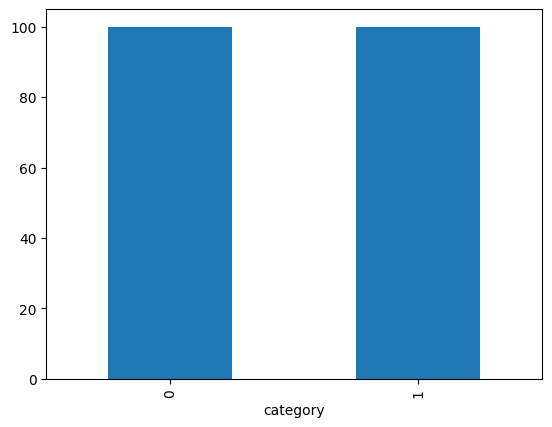

In [7]:
df['category'].value_counts().plot.bar()

In [8]:
model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [11]:
df["category"] = df["category"].replace({0:'normal', 1:'pneumonia'})
train_df,validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [12]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,"treino",
# note que o caminho para a pasta treino deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=Image_Size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "treino", 
# note que o caminho para a pasta treino deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

Found 160 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


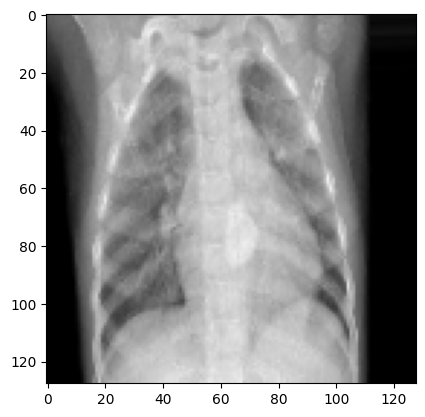

In [13]:
# Visualizando as imagens dentro do modelo
x , y  = train_generator.next()
for i in range(0,1):
    random_image = x[i]
    plt.imshow(random_image)
    plt.show()

In [14]:
epochs=10 # quantidade de épocas de treinamento. É possível aumentar ou dimunir a quantidade.
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

Epoch 1/10
10/10 [==============================] - 4s 219ms/step - loss: 1.0467 - accuracy: 0.7448 - val_loss: 2.8516 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 2s 175ms/step - loss: 0.8233 - accuracy: 0.7724 - val_loss: 3.2426 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 2s 176ms/step - loss: 0.7304 - accuracy: 0.8000 - val_loss: 7.5199 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 2s 176ms/step - loss: 0.6070 - accuracy: 0.7931 - val_loss: 10.5938 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 2s 180ms/step - loss: 0.3645 - accuracy: 0.8759 - val_loss: 11.4496 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 2s 180ms/step - loss: 0.4579 - accuracy: 0.8200 - val_loss: 16.9184 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 2s 181ms/step -

In [15]:
model.save("modelo_raio-x-torax_10epoch.h5") # documento gerado com a base de treinamento.

In [16]:
test_filenames = os.listdir("teste")
# note que o caminho para a pasta teste deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.

test_df = pd.DataFrame({
    'filename': test_filenames})

In [17]:
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                   'teste',
# note que o caminho agora é para a pasta TESTE. Atente-se para não apagar as aspas e barras duplas.
                                                   x_col='filename',
                                                   y_col=None,
                                                   target_size=Image_Size,
                                                   class_mode=None,
                                                   batch_size=batch_size)

nb_samples = test_df.shape[0]

Found 100 validated image filenames.


In [18]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

7/7 [==============================] - 1s 121ms/step


In [19]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'pneumonia': 1, 'normal': 0 })

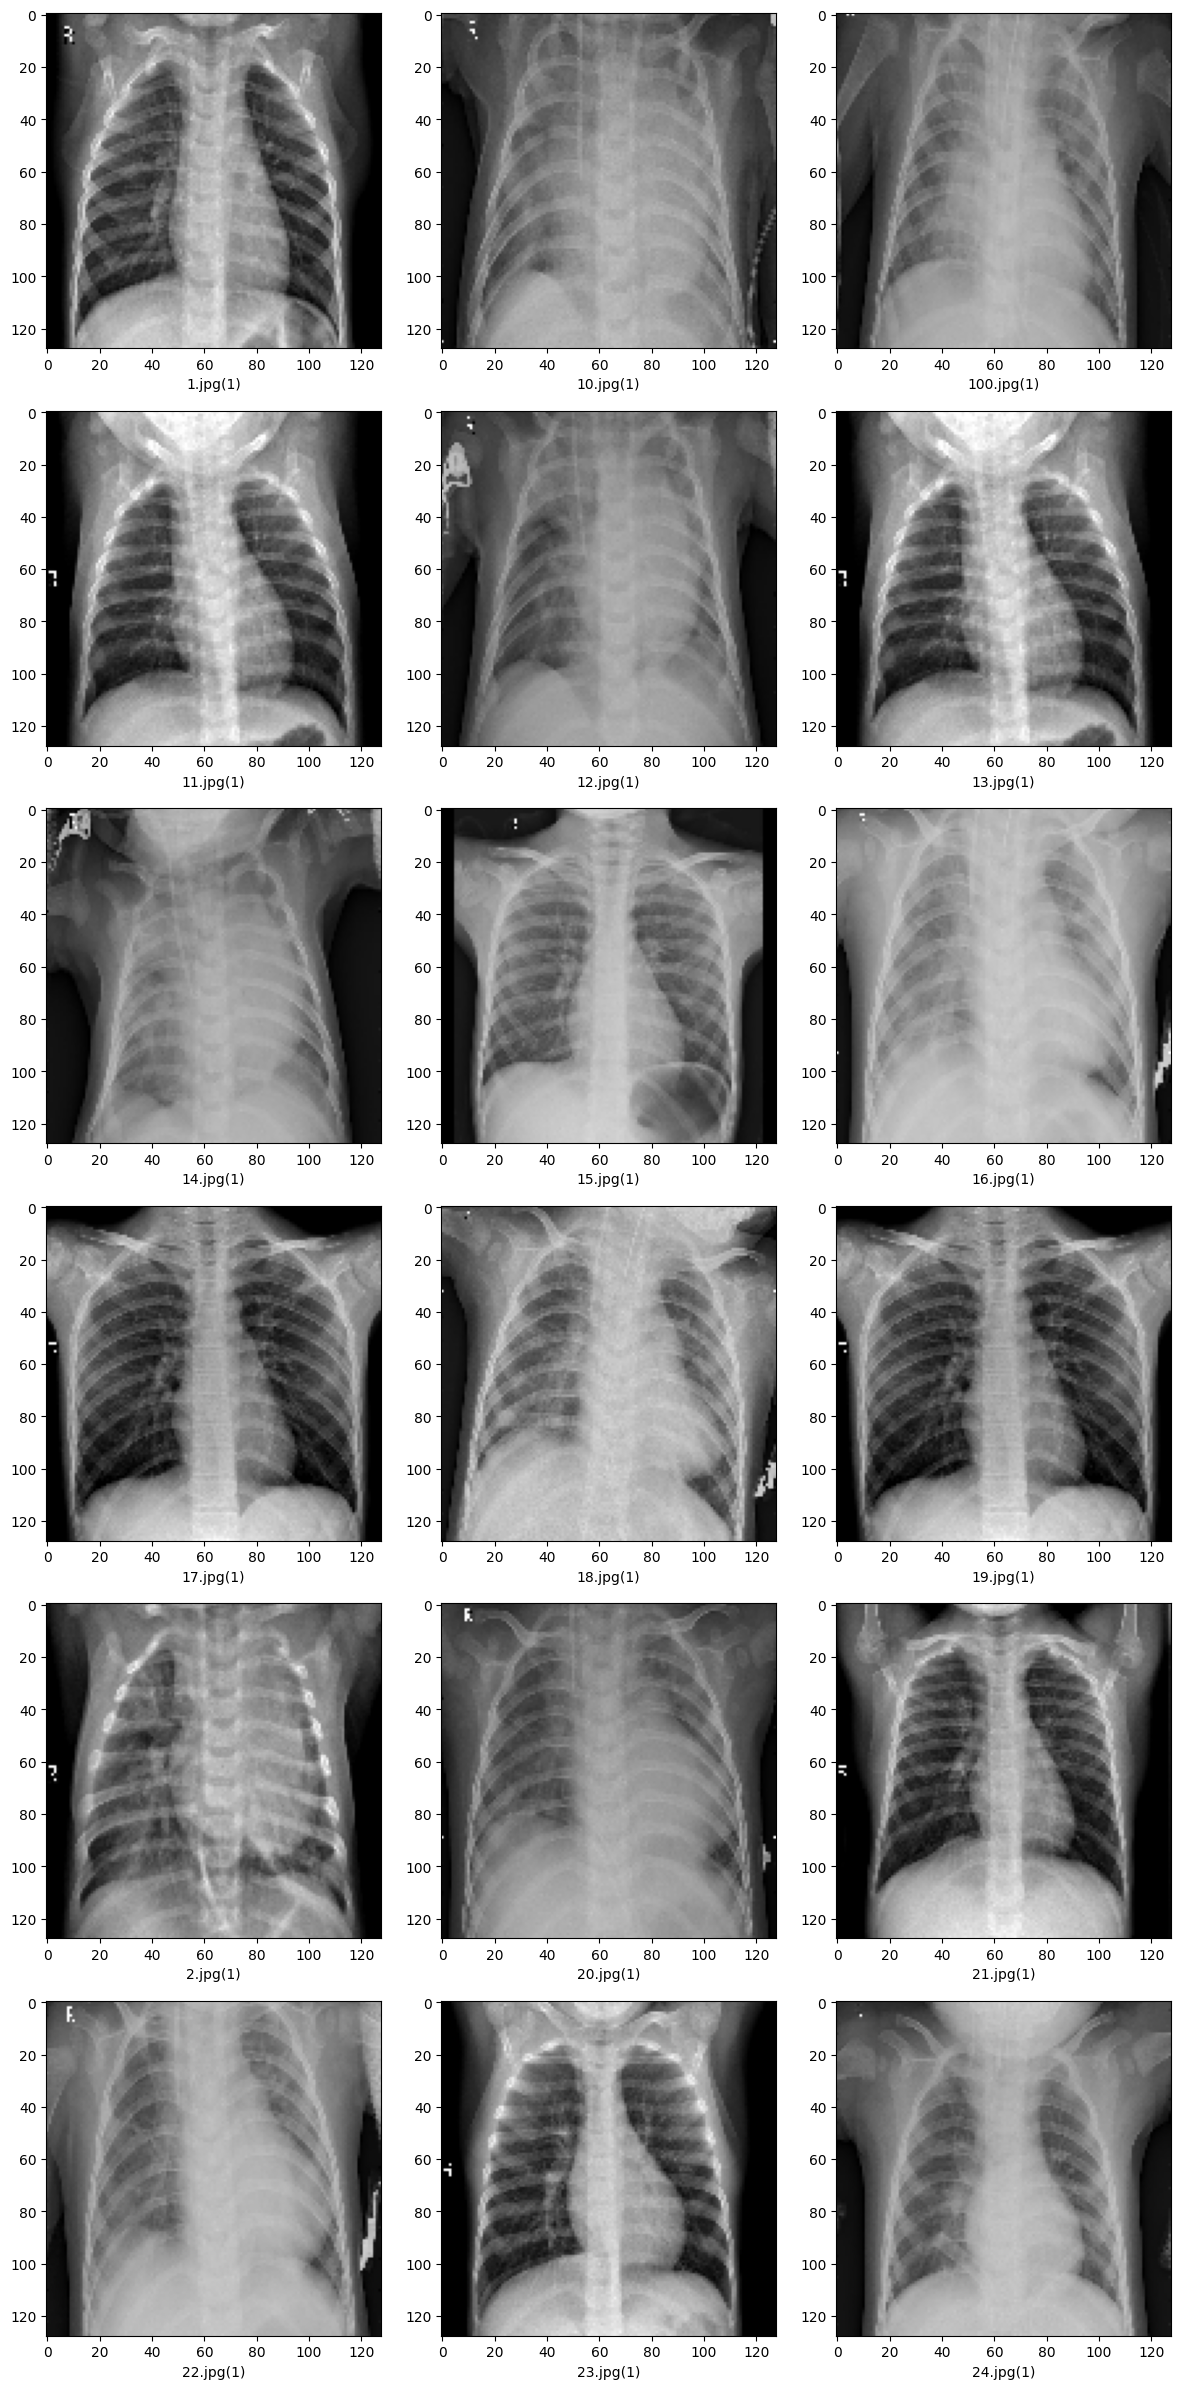

In [20]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("teste/"+filename, target_size=Image_Size)
# note que o caminho para a pasta TESTE deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [21]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import tkinter

In [24]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
import os

from keras.models import load_model

1/1 [==============================] - 0s 102ms/step
[9.9991965e-01 8.0355305e-05]
Diagnóstico indicado: RX normal


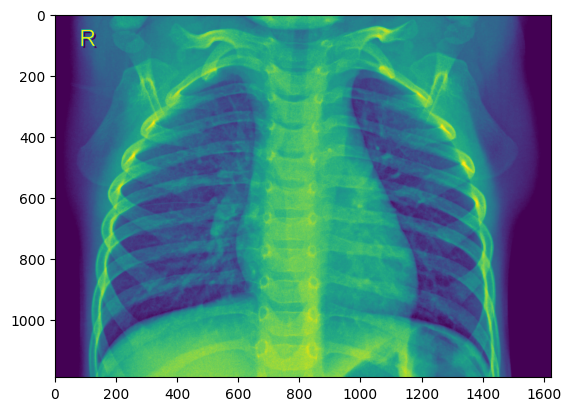

In [22]:
im=Image.open("teste/1.jpg")
# note que o caminho para a pasta TESTE deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
# escolha uma imagem para testar se é um raio x normal ou com pneumonia
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]

print(pred)

if pred[0] > pred[1]:
    print ('Diagnóstico indicado: RX normal')
else:
    print('Diagnóstico indicado: RX pneumonia')

plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 18ms/step
[9.9992645e-01 7.3492105e-05]
Diagnóstico indicado: RX normal


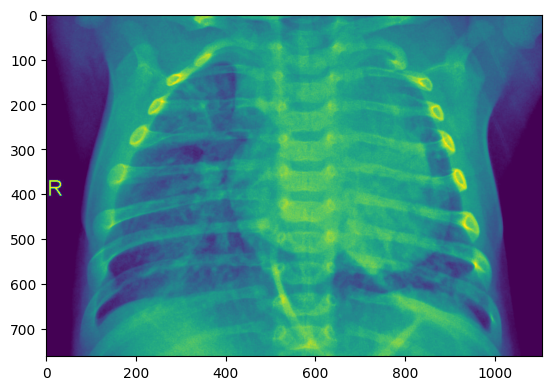

In [23]:
im=Image.open("teste/2.jpg")
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]

print(pred)

if pred[0] > pred[1]:
    print ('Diagnóstico indicado: RX normal')
else:
    print('Diagnóstico indicado: RX pneumonia')

plt.imshow(img)
plt.show()

In [25]:
model = load_model('modelo_raio-x-torax_10epoch.h5') # arquivo do modelo treinado

# Inicializando a GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Classificação para raio-x de tórax')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = (np.random.standard_normal([128,128,3])*255)
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict([image])[0]
    basename = os.path.basename(file_path)
    name = int(basename.rsplit('.', 1)[0]) 
    if name % 2:
         sign = 'Diagnóstico indicado: RX normal,'
    else:
         sign = 'Diagnóstico indicado: RX pneumonia,'
    print(sign)
    label.configure(foreground='#011638', text=f'{sign} {str(max(pred*100))} {str("%")}') 

def show_classify_button(file_path):
    classify_b=Button(top,text="Classificar imagem",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    
    except:
        pass
upload=Button(top,text="Upload da imagem",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Classificação para raio-x de tórax",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

1/1 [==============================] - 0s 98ms/step
Diagnóstico indicado: RX pneumonia,
1/1 [==============================] - 0s 19ms/step
Diagnóstico indicado: RX normal,
1/1 [==============================] - 0s 19ms/step
Diagnóstico indicado: RX normal,
1/1 [==============================] - 0s 20ms/step
Diagnóstico indicado: RX pneumonia,
1/1 [==============================] - 0s 20ms/step
Diagnóstico indicado: RX normal,
1/1 [==============================] - 0s 19ms/step
Diagnóstico indicado: RX pneumonia,
